In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm


import sys
import spikeinterface as si
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import probeinterface

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup
from probeinterface import generate_dummy_probe, generate_linear_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
from torch.nn.functional import max_pool1d


import torch.nn.functional as F
from pathlib import Path


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import Subset
import networkx as nx

# from function.Function import *

In [2]:
def count_array2_in_range_of_array1(array1, array2, threshold=5):

    sorted_array1 = np.sort(array1)
    
    lefts = array2 - threshold
    rights = array2 + threshold
    
    left_indices = np.searchsorted(sorted_array1, lefts, side='left')
    
    right_indices = np.searchsorted(sorted_array1, rights, side='right')
    
    has_within_range = right_indices > left_indices
    
    count = np.sum(has_within_range)
    
    return count


def detect_local_maxima_in_window(data, window_size=20, std_multiplier=2):

    """
    在每个滑动窗口范围内检测局部最大值的索引，并确保最大值大于两倍的标准差。

    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_rows, n_columns)。
    window_size : int
        滑动窗口的大小，用于定义局部范围，默认为 20。
    std_multiplier : float
        标准差的倍数，用于筛选局部最大值，默认为 2。

    返回:
    local_maxima_indices : list of numpy.ndarray
        每行局部最大值的索引列表，每个元素是对应行局部最大值的索引数组。
    """
    local_maxima_indices = []

    for row in data:
        maxima_indices = []
        row_std = np.std(row.astype(np.float32))
        threshold = std_multiplier * row_std

        for start in range(0, len(row), window_size):
            end = min(start + window_size, len(row))
            window = row[start:end]
            
            if len(window) > 0:
                local_max_index = np.argmax(window)
                local_max_value = window[local_max_index]
                
                if local_max_value > threshold:
                    maxima_indices.append(start + local_max_index)  
        
        local_maxima_indices.extend(maxima_indices)
        local_maxima_indices = list(set(local_maxima_indices))  

    return local_maxima_indices


def cluster_label_array1_based_on_array2(array1, array2, threshold=5):

    """
    根据 array2 的 'time' 和 'cluster' 对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 的 'time' 中，则标记为对应的 'cluster' 值，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        包含 'time' 和 'cluster' 的二维数组。
        第一列为 'time'，第二列为 'cluster'。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 array2 中的 'cluster' 或 0。
    """

    array2 = np.array(array2.iloc[:, [5, 1]])
    sorted_indices = np.argsort(array2[:, 0])
    sorted_array2 = array2[sorted_indices]
    
    labels = np.zeros(len(array1), dtype=int)
    
    # 遍历 array1 中的每个元素
    for i, value in enumerate(array1):
        # 计算当前值的范围
        left = value - threshold
        right = value + threshold
        
        left_index = np.searchsorted(sorted_array2[:, 0], left, side='left')
        right_index = np.searchsorted(sorted_array2[:, 0], right, side='right')
        
        # 如果范围内存在值，则标记为对应的 'cluster'
        if right_index > left_index:
            # 获取范围内的第一个匹配值的 'cluster'
            labels[i] = sorted_array2[left_index, 1]
    
    return labels


def label_array1_based_on_array2(array1, array2, threshold=5):

    """
    根据 array2 的值对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 中，则标记为 1，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        用于判断的数组。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 0 或 1。
    """
    # 对 array2 进行排序以加速搜索
    sorted_array2 = np.sort(array2)
    
    # 初始化标签数组，默认值为 0
    labels = np.zeros(len(array1), dtype=int)
    
    # 遍历 array1 中的每个元素
    for i, value in enumerate(array1):
        # 计算当前值的范围
        left = value - threshold
        right = value + threshold
        
        # 使用二分搜索判断范围内是否存在值
        left_index = np.searchsorted(sorted_array2, left, side='left')
        right_index = np.searchsorted(sorted_array2, right, side='right')
        
        # 如果范围内存在值，则标记为 1
        if right_index > left_index:
            labels[i] = 1
    
    return labels


def extract_windows(data, indices, window_size=61):
    """
    根据给定的时间点索引提取窗口。
    
    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_channels, time)
    indices : numpy.ndarray
        时间点索引数组，用于指定需要提取窗口的中心点
    window_size : int
        窗口长度，默认为61（对应time-30到time+31）
    
    返回:
    windows : numpy.ndarray
        提取的窗口数据，形状为 (len(indices), n_channels, window_size)
    """
    n_channels, time_length = data.shape
    half_window = window_size // 2

    if np.any(indices < half_window) or np.any(indices >= time_length - half_window):
        raise ValueError("Some indices are out of bounds for the given window size.")

    windows = []
    for idx in indices:
        window = data[:, idx - half_window:idx + half_window + 1]
        windows.append(window)

    windows = np.array(windows)
    return windows

In [3]:
recording_raw = se.MEArecRecordingExtractor(file_path='/media/ubuntu/sda/Spike_Sorting/paper_architecture/02_simulation_data/02_Neuropixel_384_channels/data_generation/recording_neuropixels_600s_350cells_fs10000.h5')

recording_f = spre.bandpass_filter(recording_raw, freq_min=300, freq_max=3000)
recording_f = spre.common_reference(recording_f, reference="global", operator="median")

In [5]:
probe_384channel = np.array(recording_raw.get_probegroup().to_dataframe().iloc[:, 1:3])

In [33]:
with PdfPages("raw_traces.pdf") as pdf:
    for i in range(0, 5):
        plt.figure(figsize=(5, 6))
        a =recording_f.get_traces(start_frame=i * 100, end_frame= (i + 1) * 100)
        sns.heatmap(a.T, cmap='coolwarm', label=False, cbar=False)
        plt.xticks([])
        plt.yticks([])
        pdf.savefig()
        plt.close()

In [16]:
a.shape

(10, 384)

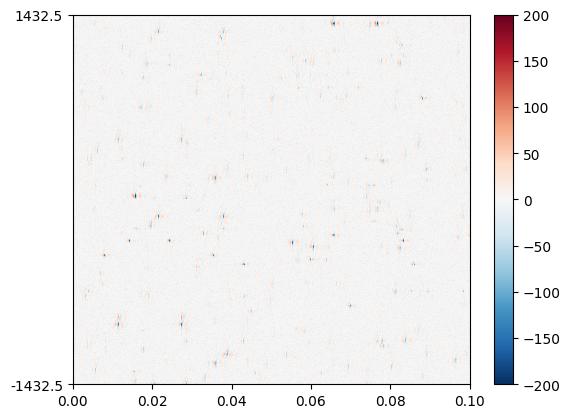

In [14]:
sw.plot_traces(recording=recording_f, time_range=(0, 0.1))

In [7]:
eps=1e-5
distance_threshold = 200
dist_matrix = np.linalg.norm(probe_384channel[:, np.newaxis] - probe_384channel, axis=2)
np.fill_diagonal(dist_matrix, 0)
dist_matrix[dist_matrix < eps] = eps
inv_dist = np.zeros_like(dist_matrix)

inv_dist = np.where(dist_matrix > 0, 1, 0)
np.fill_diagonal(inv_dist, 0)  
if distance_threshold is not None:
    inv_dist[dist_matrix > distance_threshold] = 0

graph = nx.from_numpy_array(inv_dist)
maximal_cliques = list(nx.find_cliques(graph))
cliques_dict = {i: clique for i, clique in enumerate(maximal_cliques)}

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
%matplotlib qt

def visualize_graph_with_cliques(graph, k=3, figsize=(14, 8), node_size=100, font_size=8):
    """
    可视化图结构并标记clique
    
    参数:
    - graph: NetworkX图对象
    - k: 要标记的clique大小（默认为3-clique）
    - figsize: 图形尺寸
    - node_size: 节点大小
    - font_size: 标签字体大小
    """
    # 1. 计算布局 - 使用弹簧布局并调整参数增加宽度
    pos = nx.spring_layout(
        graph, 
        k=0.2,  # 增加节点间距
        iterations=100,  # 增加迭代次数以获得更稳定的布局
        seed=42,  # 固定随机种子以保证结果可复现
        scale=2.0  # 增加整体布局比例
    )
    
    # 调整布局增加宽度 - 将y轴压缩，x轴扩展
    for node, coords in pos.items():
        pos[node] = [coords[0] * 1.5, coords[1] * 0.7]
    
    # 2. 识别clique
    cliques = list(nx.find_cliques(graph))
    k_cliques = [clique for clique in cliques if len(clique) >= k]
    
    # 3. 为不同的clique创建颜色映射
    unique_cliques = []
    for clique in k_cliques:
        # 检查是否是其他clique的子集
        is_subset = False
        for larger_clique in unique_cliques:
            if set(clique).issubset(set(larger_clique)):
                is_subset = True
                break
        if not is_subset:
            unique_cliques.append(clique)
    
    # 创建颜色映射
    colors = cm.rainbow(np.linspace(0, 1, len(unique_cliques)))
    clique_colors = {}
    for i, clique in enumerate(unique_cliques):
        for node in clique:
            # 如果节点已经在更大的clique中，保留更大clique的颜色
            if node not in clique_colors:
                clique_colors[node] = colors[i]
    
    # 4. 创建节点颜色列表
    node_colors = []
    for node in graph.nodes():
        if node in clique_colors:
            node_colors.append(clique_colors[node])
        else:
            node_colors.append('#648ace')  # 默认颜色
    
    # 5. 绘制图形
    plt.figure(figsize=figsize)
    
    # 绘制节点和边
    nx.draw_networkx_nodes(
        graph, pos, 
        node_color=node_colors, 
        node_size=node_size,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        graph, pos, 
        edge_color='lightgray', 
        alpha=0.5,
        width=0.5
    )
    
    # 6. 标记clique区域
    for i, clique in enumerate(unique_cliques):
        # 计算clique的边界框
        clique_pos = [pos[node] for node in clique]
        x_coords = [p[0] for p in clique_pos]
        y_coords = [p[1] for p in clique_pos]
        
        # 绘制凸包
        if len(clique) > 2:
            from scipy.spatial import ConvexHull
            hull = ConvexHull(clique_pos)
            
            # 绘制凸包多边形
            hull_points = [clique_pos[vertex] for vertex in hull.vertices]
            hull_x = [p[0] for p in hull_points]
            hull_y = [p[1] for p in hull_points]
            
            plt.fill(
                hull_x, hull_y, 
                color=colors[i], 
                alpha=0.15, 
                label=f'Clique (size={len(clique)})'
            )
    


# 使用示例
# visualize_graph_with_cliques(graph, k=3)

In [26]:
visualize_graph_with_cliques(
    graph, 
    k=10,
    figsize=(16, 10), 
    node_size=28, 
    font_size=0
)

In [ ]:
spike_inf = pd.read_csv("/media/ubuntu/sda/Spike_Sorting/simulation/sorting/recording_neuropixels_600s_350cells_fs10000.csv")
import MEArec
regmec = MEArec.load_recordings("/media/ubuntu/sda/Spike_Sorting/simulation/recording/fs10000/recording_neuropixels_600s_350cells_fs10000.h5")
cluster_inf = pd.read_csv("/media/ubuntu/sda/Spike_Sorting/simulation/sorting/cluster_inf_recording_neuropixels_600s_350cells_fs10000.csv")

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    

class Spike_Detection_MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, n_channels, time_window):
        super(Spike_Detection_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 16)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()  

        self.n_channels = n_channels
        self.time_window = time_window
    def forward(self, x):
        x = x.reshape(-1, self.n_channels * self.time_window)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [ ]:
for clique_id, clique in cliques_dict.items():
    print(f"Processing clique {clique_id} with {len(clique)} channels...")
    
    probe_center = np.mean(probe_384channel[clique], axis=0) 
    distance_threshold = 100  

    distances = np.linalg.norm(cluster_inf.iloc[:, 1:3] - probe_center, axis=1)

    indices_within_range = cluster_inf['Neuron'][np.where(distances <= distance_threshold)[0]].values
    spike_inf_temp = spike_inf[spike_inf['Neuron'].isin(indices_within_range)]

    total_frames = 600 * 10000
    chunk_size = 100000  
    window_size = 31
    half_window = window_size // 2

    all_valid_indices = []
    all_windows = []

    for start_frame in range(0, total_frames, chunk_size):
        end_frame = min(start_frame + chunk_size, total_frames)
        
        data_chunk = recording_f.get_traces(
            start_frame=start_frame,
            end_frame=end_frame,
            channel_ids=[str(i+1) for i in clique]
        )  # shape: (n_channels, chunk_size)
        
        threshold_result = detect_local_maxima_in_window(
            data_chunk.T,  
            std_multiplier=0.7
        )
        
        threshold_result = np.array(threshold_result) + start_frame
        valid_indices = threshold_result[
            (threshold_result >= start_frame + half_window + 1) & 
            (threshold_result < end_frame - half_window)
        ]
        
        for idx in valid_indices:
            rel_idx = idx - start_frame
            window = data_chunk.T[:, rel_idx-half_window : rel_idx+half_window+1]
            all_windows.append(window)
        
        all_valid_indices.extend(valid_indices)

    all_valid_indices = np.array(all_valid_indices)
    all_windows = np.stack(all_windows)  

    distances = np.linalg.norm(cluster_inf.iloc[:, 1:3] - probe_center, axis=1)
    indices_within_range = cluster_inf['Neuron'][distances <= distance_threshold].values
    spike_inf_temp = spike_inf[spike_inf['Neuron'].isin(indices_within_range)]

    labels = label_array1_based_on_array2(all_valid_indices, spike_inf_temp['time'], threshold=1)
    indices_0 = np.where(labels == 0)[0] 
    indices_1 = np.where(labels == 1)[0] 

    target_0_count = len(indices_1) 

    if len(indices_0) > target_0_count:
        sampled_indices_0 = np.random.choice(indices_0, target_0_count, replace=False)
    else:
        sampled_indices_0 = indices_0  

    final_indices = np.concatenate([sampled_indices_0, indices_1])

    np.random.shuffle(final_indices)

    sampled_windows = all_windows[final_indices]
    sampled_labels = labels[final_indices]

    dataset = CustomDataset(sampled_windows, sampled_labels)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    batch_size = 1024 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = sampled_windows.shape[1] * sampled_windows.shape[2]

    accuracy_list = []  
    tpr_list = []
    tnr_list = []

    criterion = nn.BCELoss()  
    
    hidden_size1 = 128
    hidden_size2 = 32
    output_size = 1  
    device = 'cuda'
    
    for trail in range(1, 6):
        print(f"Training for trail {trail}...")

        model = Spike_Detection_MLP(input_size, hidden_size1, hidden_size2, 
                                    output_size, n_channels=sampled_windows.shape[1], time_window= sampled_windows.shape[2])
        model = model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        num_epochs = 50
        tpr_best = 0
        i = 0
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            correct = 0
            total = 0
            for batch_data, batch_labels in train_loader:
                batch_labels = batch_labels.float().unsqueeze(1)

                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)

                predicted = (outputs > 0.5).float()  
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")
            #print(f"Train Accuracy: {100 * correct / total:.2f}%")

            model.eval()
            correct = 0
            total = 0

            true_positive = 0
            true_negative = 0
            false_positive = 0
            false_negative = 0

            with torch.no_grad():
                for batch_data, batch_labels in test_loader:
                    batch_labels = batch_labels.float().unsqueeze(1)
                    batch_data = batch_data.to(device)
                    batch_labels = batch_labels.to(device)

                    outputs = model(batch_data)
                    predicted = (outputs > 0.5).float()  
                    total += batch_labels.size(0)
                    correct += (predicted == batch_labels).sum().item()
                    true_positive += ((predicted == 1) & (batch_labels == 1)).sum().item()
                    true_negative += ((predicted == 0) & (batch_labels == 0)).sum().item()
                    false_positive += ((predicted == 1) & (batch_labels == 0)).sum().item()
                    false_negative += ((predicted == 0) & (batch_labels == 1)).sum().item()

            tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
            tnr = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0

            #print(f"Test Accuracy: {100 * correct / total:.2f}%")
            #print(f"Test TPR: {100 * tpr:.2f}%")
            #print(f"Test TNR: {100 * tnr:.2f}%")

            # if tpr > tpr_best:
            #             tpr_best = tpr
            #             i = 0
            #             torch.save(model, f'/media/ubuntu/sda/Spike_Sorting/simulation/Neuropixles/spike_detection_model/{trail}/clique_{clique_id}.pth')
            #             #print(f"Best model saved with TPR: {tpr_best:.4f}")
            #             #print("_" * 60)

            # else:
            #     i += 1
            #     if i == 3:
            #         #print(f"Training stopped after {epoch+1} epochs with best TPR: {tpr_best:.4f}")
            #         #print("_" * 60)
            #         break

Processing clique 0 with 28 channels...
Training for trail 1...
Training for trail 2...
Training for trail 3...
Training for trail 4...
Training for trail 5...
Processing clique 1 with 28 channels...


KeyboardInterrupt: 